# John Wu
# CSE 5524
# 11/05/22
### Libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.animation as animation
import matplotlib.cm as cm
import scipy
import scipy.ndimage
import skimage.io
import operator as op
import itertools as it
from PIL import Image
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage import morphology
from sklearn.neighbors import NearestNeighbors
# plt.rcParams['figure.figsize'] = [20, 20]

### 1) Compute a disparity map for the images left.png and right.png (having parallel optical axes) using the basic stereo matching algorithm. Use the NCC function to perform the template matching for each patch in the left image searching in the right image (search only leftward from – and including! – the starting point along each row!), and use a window size of 11x11 pixels. To make things run a bit faster for the grader, when searching leftward, only move up to 50 pixels to the left (instead of going all the way to the edge of the image). Use the following Matlab code (or Python equivalent) to display the disparity map D with a gray colormap and clip the disparity values at 50 pixels, making sure to display the full range of remaining values (e.g., using Matlab’s imagesc function): [5 pts]

    imagesc(D, [0 50]);
    axis equal;
    colormap gray;

In [2]:
def getAverageRGBN(image):
  """
  Given np Image, return average value of color as (r, g, b)
  """
  # get image as numpy array
  # get shape
  w,h,d = image.shape
  # change shape
  image = image.reshape(w*h, d)
  # get average
  return (np.mean(image, axis=0))
# NCC
# assume templateDiffs are a cube of differences in x,y,rgb plane
def ncc(templateDiffs, templateStd, patchIm):
    nPixels = templateDiffs.shape[0] * templateDiffs.shape[1]
    NCC = 0
    nRGB = 0
    if len(patchIm.shape) > 2:
        nRGB = templateDiffs.shape[2]
        patchMeans = getAverageRGBN(patchIm)#np.zeros(nRGB)
        patchStd = np.zeros(nRGB)
        nPixels = templateDiffs.shape[0] * templateDiffs.shape[1]
        for color in range(templateDiffs.shape[2]): # get rgb
            patchStd[color] = np.std(patchIm[:,:,color],ddof=1) # unbiased
        # get differences, all vectorized because otherwise it's too slow without C mappings.
        patchDiffs = np.zeros(patchIm.shape)
        for c in range(nRGB):
            patchDiffs[:, :, c] = patchIm[:,:,c] - patchMeans[c]
        NCC = np.multiply(patchDiffs, templateDiffs)
        for c in range(nRGB):
            denom = templateStd[c] * patchStd[c] # standard deviation term
        NCC[:,:,c] = np.divide(NCC[:,:,c], denom)
    else:
        patchMeans = np.mean(patchIm)
        patchStd = np.std(patchIm, ddof=1) # unbiased
        # get differences, all vectorized because otherwise it's too slow without C mappings.
        patchDiffs = patchIm - patchMeans
        NCC = np.multiply(patchDiffs, templateDiffs)
        denom = templateStd * patchStd # standard deviation term
        NCC = np.divide(NCC, denom)
        
    NCC /= (nPixels - 1) 
    NCC = np.sum(NCC)
    return NCC


def disparity(left, right, windowSize, offset=50):
    disp = np.zeros(left.shape)
    finalOriginRow = right.shape[0] - windowSize + 1
    finalOriginCol = right.shape[1] - windowSize + 1
    # for each patch in left, find corresponding in right. Horizontal row scanning
    for r in range(finalOriginRow):
        for templateC in range(finalOriginCol):
            bestCol = 0
            bestNCC = -np.inf
            templateIm = left[r:(r+windowSize), templateC:(templateC+windowSize)] # template is the one in the left patch
            templateMeans = 0
            templateStd = 0
            templateDiffs = np.zeros(templateIm.shape)
            if len(templateIm.shape) > 2:
                templateIm = left[r:(r+windowSize), templateC:(templateC+windowSize),:]
                templateMeans = np.zeros(templateIm.shape[2])
                templateStd = np.zeros(templateIm.shape[2])
                for color in range(templateIm.shape[2]):
                    templateMeans[color] = np.mean(templateIm[:,:,color])
                    templateStd[color] = np.std(templateIm[:,:,color],ddof=1)
                for color in range(templateIm.shape[2]):  
                    templateDiffs[:,:,color] = templateIm[:,:,color] - templateMeans[color]
            else: 
                templateMeans = np.mean(templateIm)
                templateStd = np.std(templateIm, ddof=1)
                templateDiffs = templateIm - templateMeans
                
            # go right to left pixel wise from starting point in left image.
            for candidateC in range(templateC, templateC - offset, -1):
                if candidateC > -1:
                    candidatePatch = right[r:(r+windowSize), candidateC:(candidateC+windowSize)]
                    if len(templateIm.shape) > 2:
                        candidatePatch = right[r:(r+windowSize), candidateC:(candidateC+windowSize),:]
                    nccScore = ncc(templateDiffs, templateStd, candidatePatch)
                    if nccScore > bestNCC:
                        bestNCC = nccScore
                        bestCol = candidateC
                    
            disp[r, templateC] = templateC - bestCol
    return disp
            
                        

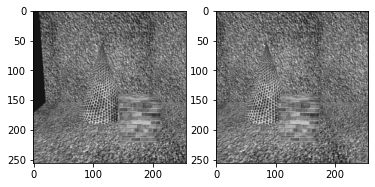

In [3]:
left = plt.imread('left.png')
right = plt.imread('right.png')
fig, ax = plt.subplots(1,2)
ax[0].imshow(left, cmap='gray')
ax[1].imshow(right, cmap='gray')

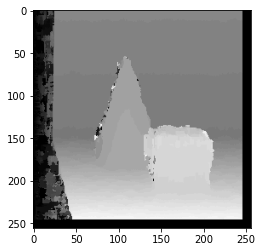

In [4]:
dispMap = disparity(left,right,windowSize=11)
plt.imshow(dispMap,cmap='gray')

In [5]:
print(np.min(dispMap))
print(np.max(dispMap))

0.0
49.0


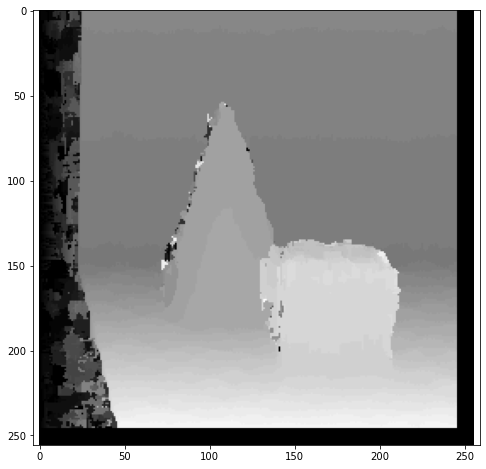

In [13]:
dispMapClipped = dispMap.copy()
dispMapClipped = np.clip(dispMapClipped, 0, 50)
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.imshow(dispMapClipped,cmap='gray')
plt.imsave("p1_dispMap.png", dispMap, cmap='gray')
plt.imsave("p1_dispMapClipped.png", dispMapClipped, cmap='gray')

#### Discussion: Cool things to note, there's a giant cube with a weird hole in it that is in front of the cone that we can clearly see. The giant cube is hard to see without this disparity map. This algorithm is also super slow if you have to scan for every single pixel. I can definitely understand now why it may be better to scan only a certain select few interest points to produce a better depth map. Also some key things to notice, the left side of the original displayed image is where there exists objects in the left that do not match any objects in the right image, which I suppose makes sense. Other things to note is that when window sizing, whether you start in the top left corner of a template "window" or you start in the center, a window size of greater than 1 pixel will invariably lead to some areas that are "unscannable" (unless you perform some special extrapolations and then compression).

### 2) Use the points in file train.txt as training data (this file contains 1 row for each data point where the first two columns are x,y coordinates and the third column is the ground truth classification label – there are 2 classes). Classify all the test data points in the file test.txt (formatted in the same way) using K=1. Calculate and report the accuracy of your algorithm (compared to the third column ground truth of the test data). Plot the test data points, color coded by the class label your algorithm gives (use plot() options 'r.' and 'b.'). On the same figure (use hold on/off), (re)plot the points which are misclassified (use plot() option 'ko' or something similar to easily identify these points). Repeat this for K=5, 11, and 15. Compare the plots and accuracy results for different values of K. [4 pts] (Note: You may use the Matlab function knnsearch()for part of this problem.)

In [7]:
# assume train contains all labels and point is just a point, note that we can use knnsearch() for this problem
def knn_predict(train, point, K):
    # get difference matrix
    X = train[:,:2]
    nbrs = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(point.reshape(1, 2))
    nearestClasses = np.zeros(K)
    for i in range(K):
        nearestClasses[i] = train[indices[0,i],2]
    
    unique, counts = np.unique(nearestClasses, return_counts=True)
    indexOfMax = np.argmax(counts)
    return unique[indexOfMax]

# note it takes in only test data, without its labels.
def KNN(train, test, K):
    predictedLabels = np.zeros(test.shape[0])
    for i in range(test.shape[0]):
        predictedLabels[i] = knn_predict(train, test[i,:], K)
    return predictedLabels

def accuracy(predicted, label):
    return (label.shape[0] - np.sum(np.abs(predicted - label))) / label.shape[0]

def plot(data, prediction, labels,K):
    plt.figure(figsize=(8,8))
    X_1 = []
    X_2 = []
    for i in range(prediction.shape[0]):
        if prediction[i] == 1:
            X_1.append(data[i,:])
        else: 
            X_2.append(data[i,:])
    X_1 = np.stack(X_1, axis=0)
    X_2 = np.stack(X_2, axis=0)
    pointSize = 10
    # plot all class 1
    plt.scatter(X_1[:,0],X_1[:,1],s=pointSize, color='r', label='Class 1')
    
    # plot all class 2
    plt.scatter(X_2[:,0],X_2[:,1],s=pointSize, color='b', label='Class 2')
    # plot all incorrect
    incorrectPredictionPoints = prediction != labels
    for i in range(incorrectPredictionPoints.shape[0]):
        if incorrectPredictionPoints[i]:
            plt.scatter(data[i,0], data[i,1], color='k',s=40, facecolors='none')
    plt.axis('equal')
    plt.legend()
    plt.savefig('K' + str(K) + '.png')
            
def problem2KNN(train, test, K):
    test_data = test[:,:2]
    test_labels = test[:,2]
    predicted = KNN(train, test_data, K)
    plot(test_data, predicted, test_labels, K)
    print("Acc:", accuracy(predicted, test_labels))
        

In [8]:
test = np.loadtxt("test.txt")
train = np.loadtxt("train.txt")



#### K = 1

Acc: 0.9676666666666667


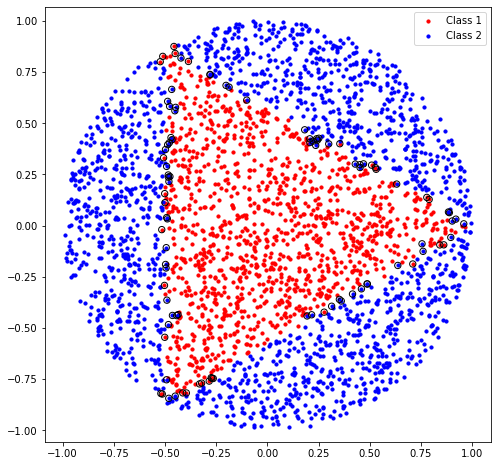

In [9]:
problem2KNN(train,test,K=1)

#### K = 5

Acc: 0.9633333333333334


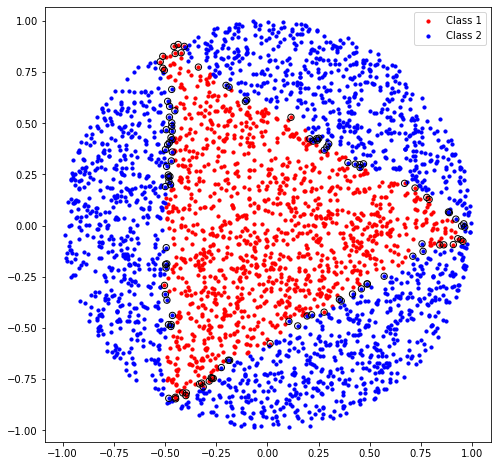

In [10]:
problem2KNN(train,test,K=5)

#### K = 11

Acc: 0.9626666666666667


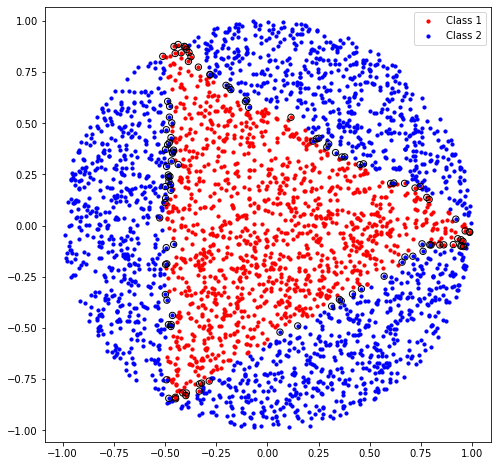

In [11]:
problem2KNN(train,test,K=11)

#### K = 15

Acc: 0.969


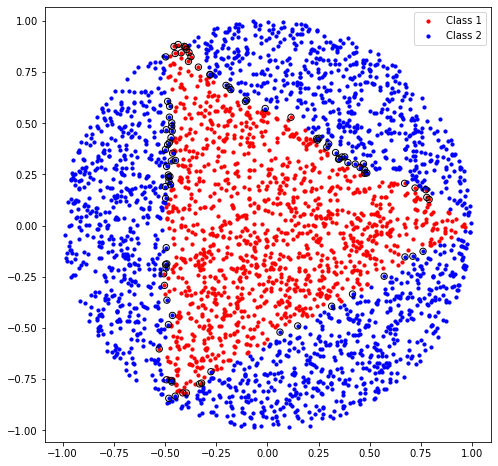

In [12]:
problem2KNN(train,test,K=15)

### Discussion: The corresponding accuracies to K=1,5,11,15 are 0.9677, 0.9633, 0.9627, 0.969. In this case, interestingly, K=15 did the best, then K=1, then K=5, then K=11, which basically meant that there wasn't an explicit ordering of which K was best. As such, it is probably extremely important to do cross-validation for a range of reasonable K values as you won't know which one performs best until you test it. Regarding each plot, they all had a triangle of class 1 in the center where misclassifications happened at the edges of the triangle between class 1 and class 2. Interestingly enough, although two corners always had mispredictions, the right corner of the triangle had its mispredictions removed once K=15, which I suppose corresponds to its highest accuracy value.